This notebook tests the output of the bioimage-search image-preprocessing service.
It assumes the "standard" organization of both the BBBC-021 dataset and the test output.

In [1]:
#!pip install shortuuid

In [2]:
import boto3
import sys
import pandas as pd
import numpy as np
import s3fs
# path setup for SageMaker Studio
sys.path.insert(0, "./bioimage-search/datasets/bbbc-021/scripts")
import bbbc021common as bb
sys.path.insert(0, "./bioimage-search/main/src/common")
import bioimageimage as bi
from PIL import Image
from skimage.exposure import histogram
import matplotlib.pyplot as plt

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [3]:
s3c = boto3.client('s3')

In [4]:
s3f = s3fs.S3FileSystem(anon=False)

In [5]:
BBBC021_SOURCE_BUCKET='bioimagesearchbbbc021stack-bbbc021bucket544c3e64-10ecnwo51127'
BIOIMAGE_SEARCH_TEST_BUCKET='bioimagesearchbasestack-bioimagesearchtestbucket3-djdwcbvul5zb'

In [6]:
plateName = 'Week10_40111'

In [7]:
Week10_40111_Info = bb.Bbbc021PlateInfo(BBBC021_SOURCE_BUCKET, plateName)

In [8]:
dapiFileList = Week10_40111_Info.getDapiFileList()

We use the DAPI channel as the index key for the full set of channels

In [9]:
testImageKey = dapiFileList[0]

In [10]:
testImageKey

'Week10_40111/Week10_200907_B10_s1_w1D637F932-45D3-470A-B113-C30ED00BC911.tif'

Load generate MIP of source images

In [11]:
def getBbbcImageFilesByDapiKey(dapiImageKey, plateInfo):
    fileKeys={}
    fileKeys['dapi']=dapiImageKey
    fileKeys['actin']=plateInfo.getActinFileByDapi(dapiImageKey)
    fileKeys['tubulin']=plateInfo.getTubulinFileByDapi(dapiImageKey)
    return fileKeys

In [12]:
t1 = getBbbcImageFilesByDapiKey(testImageKey, Week10_40111_Info)

In [13]:
t1

{'dapi': 'Week10_40111/Week10_200907_B10_s1_w1D637F932-45D3-470A-B113-C30ED00BC911.tif',
 'actin': 'Week10_40111/Week10_200907_B10_s1_w4C645C947-F0B9-405B-80A6-9357475A8C13.tif',
 'tubulin': 'Week10_40111/Week10_200907_B10_s1_w2DFB5CAD1-B3A1-4E79-A0FA-4CE6979DBE5D.tif'}

In [14]:
def getBbbcMipByDapiKey(dapiImageKey, bucket, plateInfo):
    input_arr=[]
    fileKeys = getBbbcImageFilesByDapiKey(dapiImageKey, plateInfo)
    fileArr = []
    fileArr.append(fileKeys['dapi'])
    fileArr.append(fileKeys['tubulin'])
    fileArr.append(fileKeys['actin'])
    for key in fileArr:
        fileObject = s3c.get_object(Bucket=bucket, Key=key)
        file_stream = fileObject['Body']
        im = Image.open(file_stream)
        pix = np.array(im)
        input_arr.append(pix)
    input_data = np.array(input_arr)
    input_data = bi.normImageData(input_data)

    bavgFill = np.zeros(shape=input_data[0].shape, dtype=input_data.dtype)
    for c in range(input_data.shape[0]):
        channelData = input_data[c]
        h1 = histogram(channelData, 100)
        bcut = bi.findHistCutoff(h1, 0.20)
        bavg = bi.findCutoffAvg(channelData, bcut)
        bavgFill.fill(bavg)
        bi.normalizeChannel(bavgFill, channelData)
        
    ca = bi.getColors(input_data.shape[0])
    mip = bi.calcMip(input_data, ca)
    return mip

In [15]:
mip = getBbbcMipByDapiKey(testImageKey, BBBC021_SOURCE_BUCKET, Week10_40111_Info)

In [16]:
mip.shape

(1024, 1280, 3)

In [17]:
def showNdFloatArrImage(ndarr):
    plt.figure(figsize=(20,15))
    plt.subplot(1,1,1)
    plt.xticks([])
    plt.yticks([])
    im=Image.fromarray(ndarr)
    print("shape=", im.size)
    print("format=", im.format)
    ip=plt.imshow(im)
    #plt.xlabel(0)
    plt.show()

shape= (1280, 1024)
format= None


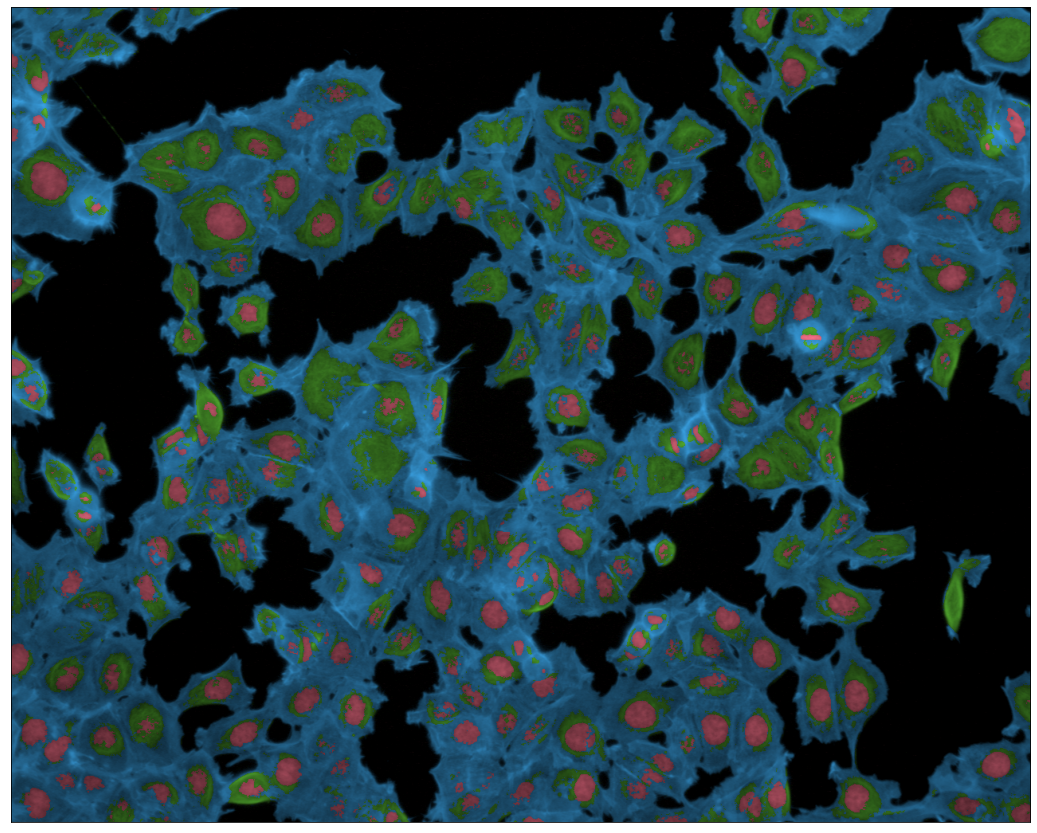

In [18]:
showNdFloatArrImage(mip)

Next, we load the ROIs and show outlines:

ROI compute:

    <output bucket>/ROI/<Plate>/<raw DAPI tif prefix>-roi.npy (contains normalized multichannel ROI data ready for training)
    <output bucket>/ROI/<Plate>/<raw DAPI tif prefix>-roi.json (contains list of ROI coordinates wrt raw image, ordered wrt the npy file)

In [22]:
def loadROIDataByDapiKey(dapiImageKey, bucket):
    roiKeyPrefix = 'ROI/' + dapiImageKey[:-4] + '-roi'
    roiDataKey = roiKeyPrefix + '.npy'
    roiJsonKey = roiKeyPrefix + '.json'
    roiData = bi.getNumpyArrayFromS3(bucket, roiDataKey)
    roiInfo = bi.loadJsonObjectFromS3(roiJsonKey, bucket)
    return roiData, roiInfo

In [23]:
roiData, roiInfo = loadROIDataByDapiKey(testImageKey, BIOIMAGE_SEARCH_TEST_BUCKET)

In [24]:
roiInfo

{'sourceImageBucket': 'bioimagesearchbbbc021stack-bbbc021bucket544c3e64-10ecnwo51127',
 'sourceChannelKeys': {'dapi': 'Week10_40111/Week10_200907_B10_s1_w1D637F932-45D3-470A-B113-C30ED00BC911.tif',
  'tubulin': 'Week10_40111/Week10_200907_B10_s1_w2DFB5CAD1-B3A1-4E79-A0FA-4CE6979DBE5D.tif',
  'actin': 'Week10_40111/Week10_200907_B10_s1_w4C645C947-F0B9-405B-80A6-9357475A8C13.tif'},
 'roisize': {'z': 1, 'y': 128, 'x': 128},
 'roi': [{'z': 0, 'y': 438, 'x': 580},
  {'z': 0, 'y': 19, 'x': 918},
  {'z': 0, 'y': 47, 'x': 348},
  {'z': 0, 'y': 54, 'x': 861},
  {'z': 0, 'y': 72, 'x': 1147},
  {'z': 0, 'y': 73, 'x': 701},
  {'z': 0, 'y': 78, 'x': 298},
  {'z': 0, 'y': 84, 'x': 1108},
  {'z': 0, 'y': 83, 'x': 639},
  {'z': 0, 'y': 91, 'x': 381},
  {'z': 0, 'y': 93, 'x': 564},
  {'z': 0, 'y': 99, 'x': 528},
  {'z': 0, 'y': 107, 'x': 792},
  {'z': 0, 'y': 109, 'x': 249},
  {'z': 0, 'y': 118, 'x': 175},
  {'z': 0, 'y': 123, 'x': 346},
  {'z': 0, 'y': 139, 'x': 127},
  {'z': 0, 'y': 135, 'x': 879},
 

In [50]:
def roiAnnotate2DDataXY(data, roiInfo, color, index=-1):
    roiSize = roiInfo['roisize']
    roiX=roiSize['x']
    roiY=roiSize['y']
    roiArr = roiInfo['roi']
    i=0
    for roi in roiArr:
        if index<0 or i==index:
            x=roi['x']
            y=roi['y']
            for xi in range(roiX):
                data[y][x+xi]=color
                data[y+roiY][x+xi]=color
            for yi in range(roiY):
                data[y+yi][x]=color
                data[y+yi][x+roiX]=color
        i+=1

In [144]:
mip2=np.copy(mip)

In [145]:
roiAnnotate2DDataXY(mip2, roiInfo, [255.0, 0.0, 0.0], 0)

shape= (1280, 1024)
format= None


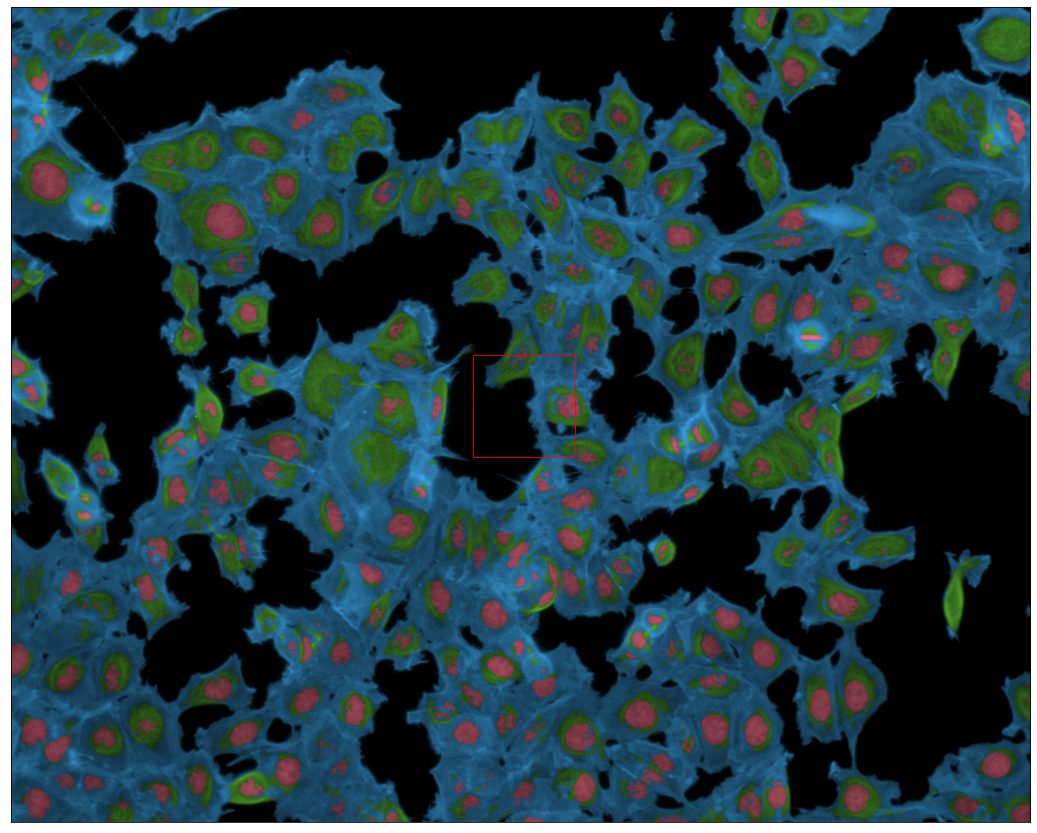

In [146]:
showNdFloatArrImage(mip2)